In [2]:
import pandas as pd 
import process
import numpy as np 

# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

In [8]:
import warnings

################## PARAMETERS #################################################################
lookback_window = [0, 250]
number_of_clusters = 20
sigma = 10e-1
clustering_method = 'signed_laplacian' 
number_of_repetition = 10
evaluation_window = 10
eta=0.01
###############################################################################################

warnings.filterwarnings('ignore')

PnL = []
overall_return = pd.DataFrame()
portfolio_value =[1]

consolidated_W_1 = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta)
portoflio_return_1 = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W_1)

lookback_window_1 = [lookback_window[0] + evaluation_window, lookback_window[1] + evaluation_window]

consolidated_W_2 = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window_1, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta)
portoflio_return_2 = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window_1, consolidated_W=consolidated_W_2)

overall_return_2 = pd.concat([portoflio_return_1, portoflio_return_2])

In [23]:
df_cleaned.shape

(695, 5279)

In [19]:
import warnings 


warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window = [0, 250]
number_of_clusters = 20
sigma = 10e-1
clustering_method = 'signed_laplacian' 
number_of_repetition = 15
evaluation_window = 1
eta=0.01
PnL = []
overall_return = pd.DataFrame()
portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period

for i in range(1, 150):

    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta, clustering_method=clustering_method)

    portfolio_return = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W)

    overall_return = pd.concat([overall_return, portfolio_return])

    lookback_window = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

    PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + portfolio_return)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après
    
    portfolio_value.append(portfolio_value[-1]+PnL[-1])

    print(portfolio_value[-1])
    
    print(f'step {i}')

1.0074028010941074
step 1
1.015114004439713
step 2
1.0208498984956413
step 3
1.0306239934561496
step 4
1.0260828483096087
step 5
1.025720842132624
step 6
1.0274599075815847
step 7
1.02800625293763
step 8
1.0245146246492398
step 9
1.0238223483209012
step 10
1.0223300947763234
step 11
1.0236286993484134
step 12
1.0235302947490224
step 13
1.0255964186759579
step 14
1.027138237403143
step 15
1.0266109887632586
step 16
1.0267059191823642
step 17
1.027007468948998
step 18
1.0277085346455122
step 19
1.0263562116478933
step 20
1.0277444498067196
step 21
1.022326344789279
step 22
1.0256016949085904
step 23
1.0281336794995481
step 24
1.025606045411401
step 25
1.0248760235363186
step 26
1.0259745218216376
step 27
1.0238741646133804
step 28
1.0253483598936326
step 29
1.0243303536062347
step 30
1.0261515087134303
step 31
1.031135078777795
step 32
1.0321338168224714
step 33
1.0339396455160945
step 34
1.034553920134674
step 35
1.0327633667531748
step 36
1.0353981166511192
step 37
1.037535442334697
st

ValueError: operands could not be broadcast together with shapes (250,) (229,) 

In [26]:
overall_return[60:65]

,portfolio return
17/04/2008,-0.006480
15/07/2008,-0.009437
10/10/2008,-0.022709
12/01/2009,0.001562
15/04/2009,0.009595


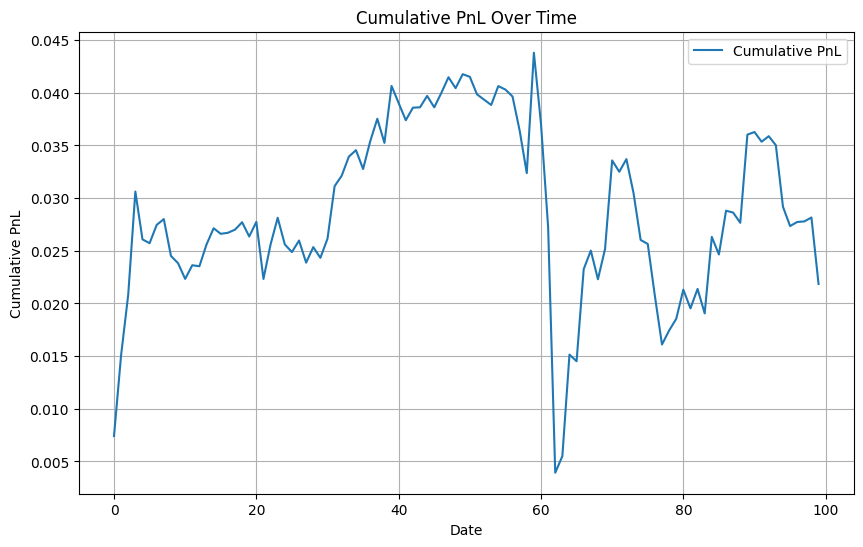

In [25]:
cumulative_PnL = (1 + overall_return).cumprod() - 1

import matplotlib.pyplot as plt


# Tracez le PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(PnL.cumsum(), label='Cumulative PnL')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

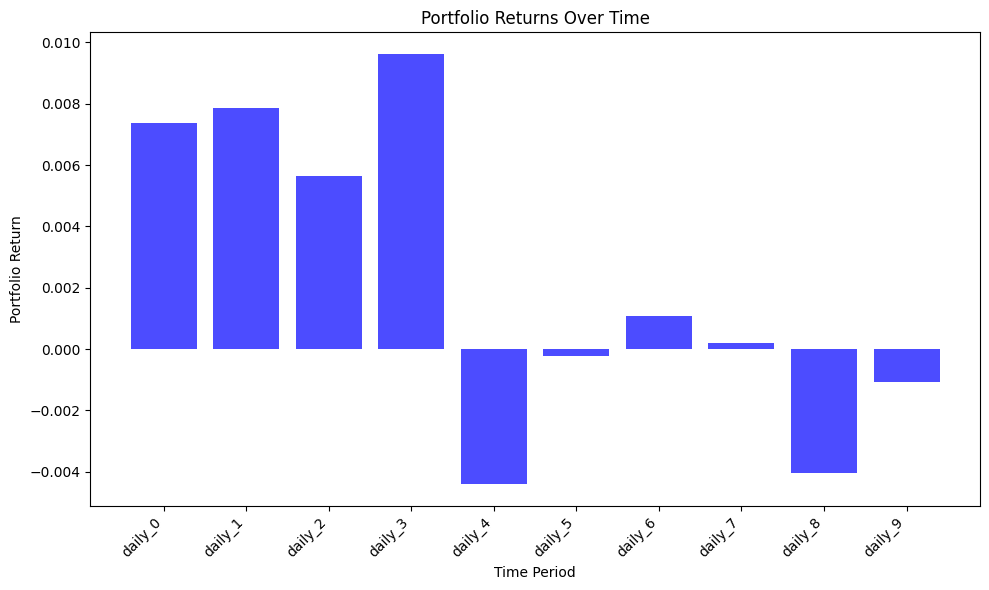

In [8]:
process.bar_plot_PnL(PnL)
